In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


* Set of stimuli $\left\{ i \right\}$
* Dirichlet prior param $\alpha$
* Random effect prior gamma prior means $\bar{\mu}^{re,d}$ and $\bar{\mu}^{re,r}$, for diagonal and off diagonal respectively
* Model precision magnitude param $\bar{o}$
* $\mathbf{1}_{4}=(1,1,1,1)$ and $\mathbf{e}_{2}=(0, 1, 0, 0)$

For each stimulus $i$ we have an emotion distribution $\vec{p}_{i}\in\Delta^{3}$ with prior
* $\vec{p}_{i} \sim Dir\left(\left(\alpha /4 \right) \mathbf{1}_{4} \right)$.

For patients with schizophrenia, we assume there is a "screen" between them and the video that "rotates" the video's emission distribution such that a particle of emotion $j$ emitted by the video and intercepted by this screen has an emission distribution of 
* $\vec{\beta}_{j}\in\Delta^{3}$ 
* with prior 
  * $\vec{\beta}_{j} \sim Dir\left(\left(\alpha /4 \right) \mathbf{1}_{4} \right)$.

We then assume that every subject has a "personal" screen that does the same thing, but with a "personal" distribution. The personal distribution for subject $k$ taking a particle of emotion $j$ has dirichlet distribution

* $\vec{r}_{j,k} \vert \mu^{re,d}, \mu^{re,r} \sim Dir\left( \mu^{re,d}\mathbf{e}_{j} + \mu^{re,r} \mathbf{1}_{4} \right)$

* where the diagonal and off diagonal parameters have priors

  * $\mu^{re,d} \sim \Gamma\left(\alpha=2, \beta= \bar{\mu}^{re,d} \right)$

  * $\mu^{re,r} \sim \Gamma\left(\alpha=2, \beta= \bar{\mu}^{re,r} \right)$


So lets say the emotion of a particle emitted from a stimulus is $x_{0}$. Then the particle's value after passing through the first screen has distribution 
* $x_{1} \vert x_{0}, \text{SZ}_{k}, \vec{\beta} \sim Multinoulli\left(\vec{\beta}_{x_{0}}\right)$
* $x_{1} \vert x_{0}, \text{HC}_{k}, \vec{\beta} \sim \delta_{x_{0}}$

And after passing through the second screen 
$ x_{2} \vert x_{1}, k, \vec{r} \sim Multinoulli\left(\vec{r}_{x_{1}, k}\right)$

And $x_{2}$ is passed to the GoEmotions model. The model, however, is imperfect. We model its precision (inverse of its noise magnitude; using "precision" and "noise magnitude" colloquially) as 
* $\mathscr{o} \sim HalfCauchy\left(\bar{o}\right)$

And model what is received by our final metric as
$ y \vert x_{2}, \mathscr{o} \sim Dir$



In [10]:
import model as go_model_module
import preprocess as go_preprocess
import pathlib
import pandas as pd
import arviz as az
import pymc3 as pm
data_path = pathlib.Path("go_emotions_output_clean.csv")
with data_path.open("r") as fl:
    raw_data = pd.read_csv(fl)
df = go_preprocess.fine_to_coarse(raw_data.rename(columns={"stimulus.x":"stim"}), 1.0)
go_preprocess.fine_to_coarse(raw_data.rename(columns={"stimulus.x":"stim"}), None, True)

     realization  surprise  confusion  curiosity     anger  annoyance  \
0       0.033654  0.033654   0.033660   0.033658  0.033677   0.033677   
1       0.031850  0.031851   0.031873   0.031894  0.031851   0.031847   
2       0.036213  0.033979   0.033806   0.033819  0.033793   0.033802   
3       0.033277  0.033258   0.033391   0.034302  0.033253   0.033260   
4       0.033797  0.033658   0.033671   0.033671  0.033631   0.033630   
..           ...       ...        ...        ...       ...        ...   
857     0.033480  0.033511   0.033506   0.033564  0.033461   0.033458   
858     0.033767  0.033637   0.033640   0.033644  0.033643   0.033704   
859     0.034461  0.033919   0.033964   0.033863  0.033830   0.033856   
860     0.033307  0.032961   0.032921   0.032935  0.032893   0.032920   
861     0.032991  0.032967   0.033073   0.033007  0.032992   0.032990   

     disappointment  disapproval   disgust  embarrassment  ...  approval  \
0          0.033655     0.033661  0.033663     

,pid,stim,dc,ambiguous,negative,neutral,positive,stim_rating
0,7001,joy_grandpa,OT,0.134626,0.370250,0.091207,0.403917,joy
1,7001,joy_baby,PL,0.127467,0.350370,0.031879,0.490284,joy
2,7001,neg_lightsout,PL,0.137817,0.374414,0.033899,0.453870,neg
3,7001,neg_dying,PL,0.134227,0.420604,0.033201,0.411967,neg
4,7001,neu_cafe,PL,0.134797,0.370454,0.090931,0.403818,neu
...,...,...,...,...,...,...,...,...
857,8110,neg_heart,HC,0.134061,0.368100,0.033494,0.464345,neg
858,8110,neu_yawn,HC,0.134688,0.370165,0.033648,0.461499,neu
859,8110,neg_nuts,HC,0.136207,0.421883,0.034474,0.407436,neg
860,8110,neg_bugear,HC,0.132122,0.365092,0.032927,0.469859,neg


In [19]:
from importlib import reload
reload(go_preprocess)
go_preprocess.fine_to_coarse(raw_data.rename(columns={"stimulus.x":"stim"}), None, True)

,pid,stim,dc,ambiguous,negative,neutral,positive,stim_rating
0,7001,joy_grandpa,OT,0.134626,0.370250,0.091207,0.403917,joy
1,7001,joy_baby,PL,0.127467,0.350370,0.031879,0.490284,joy
2,7001,neg_lightsout,PL,0.137817,0.374414,0.033899,0.453870,neg
3,7001,neg_dying,PL,0.134227,0.420604,0.033201,0.411967,neg
4,7001,neu_cafe,PL,0.134797,0.370454,0.090931,0.403818,neu
...,...,...,...,...,...,...,...,...
857,8110,neg_heart,HC,0.134061,0.368100,0.033494,0.464345,neg
858,8110,neu_yawn,HC,0.134688,0.370165,0.033648,0.461499,neu
859,8110,neg_nuts,HC,0.136207,0.421883,0.034474,0.407436,neg
860,8110,neg_bugear,HC,0.132122,0.365092,0.032927,0.469859,neg


In [ ]:

eps = 1e-6
for emo in go_preprocess.coarse_emo_list:
    df.loc[df[emo] < eps, emo] = eps
    df.loc[df[emo] > 1.0 - eps, emo] = 1.0 - eps

include_ot = True
model = go_model_module.bayesian_model(df, include_ot=include_ot, dirichlet_alpha=1.0)
temp_trace = pm.sample(
    150, model=model, return_inferencedata=True, tune=250, chains=2, 
)
trace_vars = ["re_diag", "re_rest", "beta", "obs_mag", "normative_emo"]
if include_ot:
    trace_vars.append("beta_drug")
az.plot_trace(
    temp_trace,
    var_names=trace_vars,
    compact=True,
)

,sigmoid2.0,sigmoid4.0,sigmoid6.0,1.0
stim,,,,
joy_baby,0.043986,0.036687,0.067088,0.075110
joy_dogfail,0.120389,0.303714,0.597103,0.632574
joy_grandpa,0.950810,0.912106,0.887512,0.772349
joy_phone,0.436782,0.836682,0.353928,0.035423
neg_broken,0.447416,0.629967,0.867610,0.743099
neg_bugear,0.737137,0.793354,0.484323,0.466285
neg_coffer,0.349929,0.171977,0.137153,0.483751
neg_dying,0.757281,0.734530,0.639900,0.349190
neg_heart,0.999757,0.568628,0.667697,0.735601


KeyError: 'sigmoid'

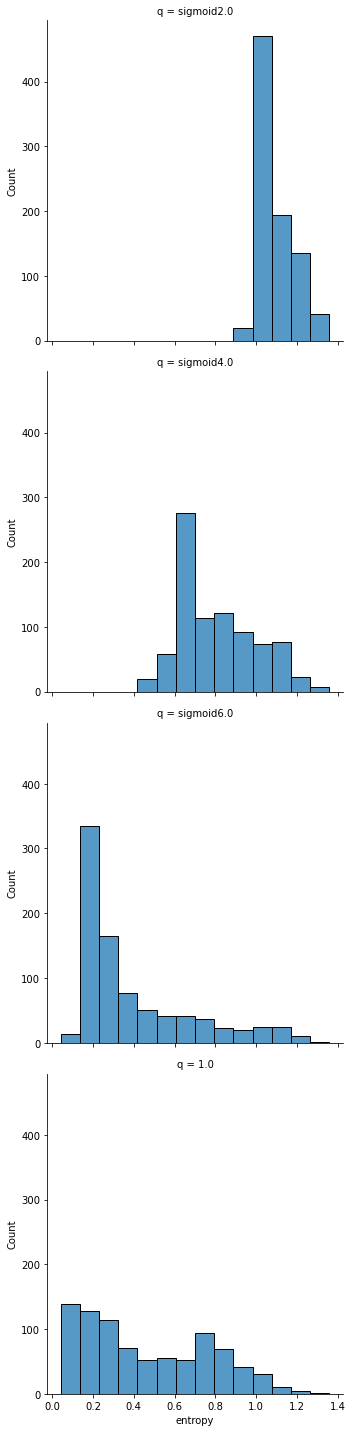

In [22]:
from scipy.stats import ttest_ind
def get_pval(df, colname="entropy"):
    _, pval = ttest_ind(df.loc[df["dc"]=="PL", colname], df.loc[df["dc"]=="HC", colname])
    return pval
zz = {}
pval_dict = {}
for q, ss in zip([None, None, None, 1.0], [2.0, 4.0, 6.0, 1.0]):
    df = go_preprocess.fine_to_coarse(raw_data.rename(columns={"stimulus.x":"stim"}), q, True, ss)
    if q is None:
        q = "sigmoid" + str(ss)
    pp = df[go_preprocess.coarse_emo_list]
    ent = (-pp * np.log(pp)).sum(1)
    zz[q] = ent
    df["entropy"] = (-pp * np.log(pp)).sum(1)
    
    pval_dict[q] = df.groupby("stim").apply(get_pval)

import seaborn as sns
zz = pd.DataFrame(zz)
zz.columns.name = "q"
zz = zz.stack()
zz.name = "entropy"
zz = zz.reset_index()
sns.displot(data=zz, x="entropy", row="q")
# sns.displot(data=df,  x="entropy")
pval_df = pd.DataFrame(pval_dict)
display(pval_df)
(pval_df["sigmoid"] > pval_df[1.0]).mean()

,sigmoid,0.5,1.0,1.5,2.0
stim,,,,,
joy_baby,0.051336,0.025982,0.075110,0.097889,0.096705
joy_dogfail,0.467286,0.463356,0.632574,0.742431,0.824883
joy_grandpa,0.933161,0.332150,0.772349,0.862911,0.862109
joy_phone,0.522487,0.096482,0.035423,0.056518,0.053496
neg_broken,0.762449,0.980675,0.743099,0.482360,0.302274
neg_bugear,0.575501,0.891618,0.466285,0.345567,0.348669
neg_coffer,0.144673,0.384273,0.483751,0.388134,0.378707
neg_dying,0.694732,0.385839,0.349190,0.722438,0.977299
neg_heart,0.567557,0.887346,0.735601,0.519324,0.335316


0.5

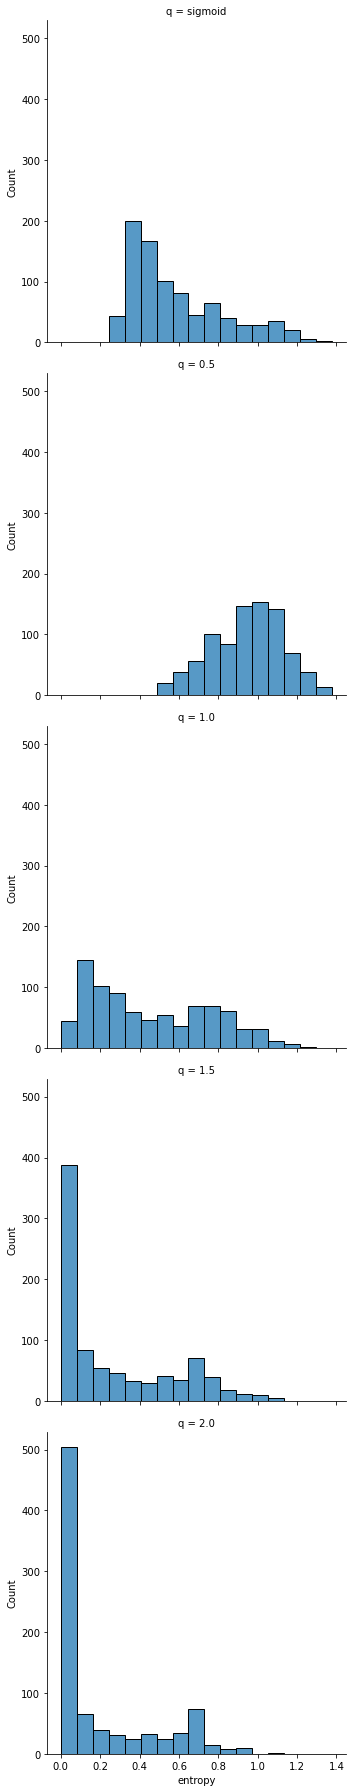

In [18]:
from scipy.stats import ttest_ind
def get_pval(df, colname="entropy"):
    _, pval = ttest_ind(df.loc[df["dc"]=="PL", colname], df.loc[df["dc"]=="HC", colname])
    return pval
zz = {}
pval_dict = {}
for q in [None, 0.5, 1.0, 1.5, 2.0]:
    df = go_preprocess.fine_to_coarse(raw_data.rename(columns={"stimulus.x":"stim"}), q, True)
    if q is None:
        q = "sigmoid"
    pp = df[go_preprocess.coarse_emo_list]
    ent = (-pp * np.log(pp)).sum(1)
    zz[q] = ent
    df["entropy"] = (-pp * np.log(pp)).sum(1)
    
    pval_dict[q] = df.groupby("stim").apply(get_pval)

import seaborn as sns
zz = pd.DataFrame(zz)
zz.columns.name = "q"
zz = zz.stack()
zz.name = "entropy"
zz = zz.reset_index()
sns.displot(data=zz, x="entropy", row="q")
# sns.displot(data=df,  x="entropy")
pval_df = pd.DataFrame(pval_dict)
display(pval_df)
(pval_df["sigmoid"] > pval_df[1.0]).mean()

In [ ]:
 df = go_preprocess.fine_to_coarse(raw_data.rename(columns={"stimulus.x":"stim"}), 1.0, False)
 df["onesum"] = df[go_preprocess.coarse_emo_list].sum(1)
 sns.displot(data=df, x="onesum", row="stim", hue="dc")

In [ ]:
ppp = df[go_preprocess.coarse_emo_list].divide( df[go_preprocess.coarse_emo_list].sum(1), 0)
df["ent"] = (-ppp * log(ppp)).sum(1)
df

In [ ]:
sns.displot(data=df, x="rawsum", y="ent", row="stim", hue="dc")

In [ ]:
df = go_preprocess.fine_to_coarse(raw_data.rename(columns={"stimulus.x":"stim"}), 1.0, False)
df["logl2"] = np.sqrt((np.log(df[go_preprocess.coarse_emo_list])**2.0).sum(1))
df.groupby("stim").apply(get_pval, colname="logl2")
# sns.displot(data=df, x="logl2", hue="dc", row="stim")

In [ ]:
df["rawsum"] = df[go_preprocess.coarse_emo_list].sum(1)
df

In [ ]:
fefit = smf.ols("rawsum ~ stim", data=df).fit()
fefit.summary()

In [ ]:
fefit.scale, mdf.scale

In [ ]:
from statsmodels import api as sm
import statsmodels.formula.api as smf
md = smf.mixedlm("logl2 ~ stim + dc", data=df, groups=df["pid"])
mdf = md.fit()

print(sqrt(mdf.cov_re.loc["Group", "Group"]) / mdf.scale)
display(mdf.summary())

In [ ]:
zz

In [ ]:
sns.displot(data=zz, x="entropy", row="q")

In [1]:
sqrt(0.007
)

NameError: name 'sqrt' is not defined

In [ ]:
display(pd.DataFrame(pval_dict).round(2).sort_values(by=1.0))

In [ ]:
temp_trace.extend(az.from_pymc3(prior=pm.sample_prior_predictive(model=model)))
az.plot_dist_comparison(temp_trace, var_names=["beta"])
az.plot_dist_comparison(temp_trace, var_names=["normative_emo"])


In [ ]:
df["stimulus.x"].value_counts()

In [ ]:
df.loc[df["stimulus.x"]=="neg_bugbear", "stimulus.x"] = "neg_bugear"

In [ ]:
df.loc[df["stimulus.x"]=="neg_cafe", "stimulus.x"] = "neu_cafe"

In [ ]:
df.loc[df["stimulus.x"]==" neg_nuts", "stimulus.x"] = "neg_nuts"

In [ ]:
df["stimulus.x"].value_counts()

In [ ]:
df.columns

In [ ]:
df.to_csv("go_emotions_output_clean.csv", index=False)

In [ ]:
import pymc3 as pm

In [ ]:
import yaml

In [ ]:
positive_emotions = [
    "admiration",
    "amusement",
    "approval",
    "caring",
    "desire",
    "excitement",
    "gratitude",
    "joy",
    "love",
    "optimism",
    "pride",
    "relief",
]
negative_emotions = [
    "anger",
    "annoyance",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "fear",
    "grief",
    "nervousness",
    "remorse",
    "sadness",
]
ambiguous_emotions = ["realization", "surprise", "confusion", "curiosity"]
neutral_emotions = ["neutral"]
coarse_to_fine_emo_map = {
    "positive": positive_emotions,
    "negative": negative_emotions,
    "ambiguous": ambiguous_emotions,
    "neutral": neutral_emotions,
}
coarse_to_fine_emo_map

In [ ]:
import pathlib
coarse_to_fine_emo_map_path = pathlib.Path("./coarse_to_fine_emo_map.yaml")
with coarse_to_fine_emo_map_path.open("w") as fl:
    yaml.dump(coarse_to_fine_emo_map, fl)

In [ ]:
import arviz

In [ ]:
az = arviz

In [ ]:
az.InferenceData